# CS236605: Deep Learning

## Final project - Glassman Yair, Vanelli Martina

Our project is based on the article [Adversarial Attacks on Neural Networks for Graph Data](https://arxiv.org/pdf/1805.07984.pdf) (Code: [code](https://github.com/danielzuegner/nettack)). 

The authors did blablabla.

The idea of or project is blablabla.

In [25]:
from matplotlib import pyplot as plt
%matplotlib inline
from nettack import utils, GCN
from nettack import nettack as ntk
import numpy as np
gpu_id = None # set this to your desired GPU ID if you want to use GPU computations (only for the GCN/surrogate training)

#our code
from importlib import reload 
import random
from nettack import sbm
import scipy.sparse as sp


### Load network, basic setup

Function that computes the average(mean?) values in order to have a starting point for the SBM parameters that is coherent with the dataset.

In [26]:
#INPUT: 
#neighbors: list (?) of length N (number of vertices), entry i contains the list/vector/? of the nrighbors of vertex i
#num_communities: integer that represents the number of communities (that is also the number of labels)
#community_labels: for each vertex, his community/label
#norm=True if we want the probabilities (if we want just the number of links between each couple of communities
#     we can set norm to be false)


def avg_matrix(neighbors, num_communities, community_labels, norm=True, ):
    
    #initialization of the matrix avg_p_matrix 
    #each entry of this matrix represents the fraction of the number of links between couples that come 
    #respectively from community i and community j over the sum of all the possibles links that could occur between elements
    #community i and community j
    avg_p_matrix=np.zeros([num_communities,num_communities])
    
    #N=number of vertices
    N=len(neighbors)
    
    #initialize the vector of vertices' indices, that is a vector that goes from 0 to N-1, 
    #each number represents a different vertex
    vertices=np.array(range(0,N))
    
    #initialization of the vector dens_communities
    #for each entry (index that represents a community/label), it memorizes how many vertices there are in that community
    dim_communities=np.zeros(num_communities)
    #computes the values and fills the vector
    for i in range(num_communities):
        dim_communities[i]=len(vertices[community_labels==i])
    
    #computes the percentage of links within each couples of communities over all the possible links within these 2 communities
    for i in range(num_communities):
        #n=vertices[community_labels==i].sum()
        #n=0
        temp=np.copy(community_labels)
        #for each vertex in that community(label)
        for v in vertices[community_labels==i]:
                
                flag=0
                #n=n+1
                temp[vertices<v]=-1
                avg_p_matrix[i,i]+=(temp[neighbors[v]]==i).sum()#/(N-1)
                
                #avg_p_matrix[i,i]+=(community_labels[neighbors[v]]==i).sum()/degrees[v]
                
                #avg_p_matrix_overall[i,i]=(community_labels[neighbors[v]]==i).sum()/N
                    
                for j in range(num_communities):
                    if i!=j:
                        avg_p_matrix[i,j]+=(community_labels[neighbors[v]]==j).sum()#/(N-1)
                        #avg_p_matrix[i,j]+=(community_labels[neighbors[v]]==j).sum()/degrees[v]
                        
                        #if (i==0 and j==1) or (i==1 and j==0):
                            #print(neighbors[v])
                            #print(community_labels[neighbors[v]])
                            #print((community_labels[neighbors[v]]==j).sum()/degrees[v])
                    #flag=0
                #print((community_labels[neighbors[v]]==i).shape[0])
                if flag==1:
                    print(neighbors[v])
                    print(community_labels[neighbors[v]])
                    print((community_labels[neighbors[v]]==i).sum()/N)
                    print((community_labels[neighbors[v]]==i).sum()/degrees[v])
                    flag=0
                
        
        #if i==0:
        #    print(avg_p_matrix[i,i])
        #avg_p_matrix[i,:]=avg_p_matrix[i,:]/n
        for j in range(num_communities):
            avg_p_matrix[i,j]=avg_p_matrix[i,j]/(dim_communities[j]*dim_communities[i])
        #avg_p_matrix_overall[i,i]=avg_p_matrix_overall[i,i]/n
    return avg_p_matrix#, avg_p_matrix_overall

In [27]:
#load the data
#_A_obs: adjacency matrix for links (structure)
#_X_obs: features per each node  
#_z_obs: labels per each node
_A_obs, _X_obs, _z_obs = utils.load_npz('data/citeseer.npz')

#make the graph indirected, that is make the adjacency matrix _A_obs symmetric
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1

print_matrix=False
if(print_matrix):
    print(_A_obs)
    
#we select just the largest connected component    
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc][:,lcc]
_X_obs = _X_obs[lcc].astype('float32')
_z_obs = _z_obs[lcc]

#N=number of vertices        
N=_A_obs.shape[0]
vertices=np.array(range(0,N))
#number of communities/labels
num_communities=_z_obs.max()+1
neighbors=[]
degrees=np.zeros(N)
for i in range(N):
    neighbors.append(_A_obs[i].nonzero()[1])
    degrees[i]=len(neighbors[i])

print_stats=True
if(print_stats):
    print("STATISTICS OVER THE DATA")
    for i in range(4):
        print("# nodes with",i,"degree:")
        print((degrees==i).sum())
    print("# nodes with degree less than average:")
    print((degrees<sum(degrees)/len(degrees)).sum())
    print("# nodes with degree greater than average:")
    print((degrees>sum(degrees)/len(degrees)+10).sum())
    print("max degree:")
    print(max(degrees))
    #print(neighbors[np.argmax(degrees)])
    #print(np.argmax(degrees))
    print("average:")
    print(sum(degrees)/len(degrees))
    for i in range(num_communities):
        print("degree average for community",i,":")
        print(sum(degrees[vertices[_z_obs==i]])/len(degrees[vertices[_z_obs==i]]))

#vector that stores with the # of nodes for each community
dim_communities=np.zeros(num_communities)
#computes the values and fills the vector
for i in range(num_communities):
    dim_communities[i]=len(vertices[_z_obs==i])

#upper triangular matrix of _A_obs,used to compute the number of links bewteen members of 
#the same community
temp=sp.triu(_A_obs,k=0).todense()
#one can put norm=False is he wants to print the total number of links instead of the
#normalized value (without the norm, the result is meaninful for the creation of the random graph) 
norm=True
#matrix that stores the estimated probabilities of presence of an edge that links members of 
#different communities, that is, for each couple of communities, average values of the number of links present in the graphs 
#over the number of possible link between the 2 communities.
#It also stores the probability of an edge that links members of the same community.
p_hat=np.zeros([num_communities,num_communities])
#for each community
for i in range(num_communities):
    #total number of edges that link members of community i 
    p_hat[i][i]=temp[_z_obs==i][:,_z_obs==i].sum()
    #this value has to be normalized over the total number of possible edges that link
    #members of the same community, that is n+dim_i(dim_i-1)/2= (dim_i)(dim_i+1)/2
    if norm:    
        p_hat[i][i]=2*p_hat[i][i]/(dim_communities[i]*(dim_communities[i]+1))
    #for all the other communities
    for j in range(i+1, num_communities):
        #total number of edges that link a member of community i and a member of community j
        p_hat[i][j]=_A_obs[_z_obs==i][:,_z_obs==j].sum()
        #over all the possible links, that is dim_i*dim_j
        if norm:
            p_hat[i][j]=p_hat[i][j]/(dim_communities[i]*dim_communities[j])
        p_hat[j][i]=p_hat[i][j]
        
check=False
if check:
    community_distribution=avg_matrix(neighbors, _z_obs.max()+1, _z_obs )
    print(community_distribution)

print_avg=True
if(print_avg):
    print(p_hat)

#we will call strongest_comm the community that has the highest probability to have an edges
#that link members of the same community
strongest_comm=np.argmax(np.diag(p_hat))
temp=(p_hat-np.diag(np.diag(p_hat))).sum(axis=1)
#print(temp)
strongest_comm_2=np.argmax(np.diag(p_hat)-temp)
#stongest_comm=np.argmax(np.diag(p_hat))
#weakest_comm has the lowest probability
weakest_comm=np.argmin(np.diag(p_hat))
weakest_comm_2=np.argmin(np.diag(p_hat)-temp)
print("The community that is most connected is: ")
print(strongest_comm, strongest_comm_2)
print("The community that is less connected is: ")
print(weakest_comm, weakest_comm_2)

#strong=False
#if strong:
#    p_hat[strongest_comm][strongest_comm]=p_hat[strongest_comm][strongest_comm]*10
#print(p_hat)
strong=True
n=50
if strong:
    for i in range(num_communities):
        p_hat[i][i]=p_hat[i][i]*n

weak=False
if weak:
    p_hat[weakest_comm][weakest_comm]=p_hat[weakest_comm][weakest_comm]/n
    
print_changes=False
if print_changes:
    print(p_hat)


#_A_obs=sp.csr_matrix(sbm.SBM(N, _z_obs.max()+1, _z_obs, (community_distribution+np.eye(_z_obs.max()+1)*100)/N).block_matrix)
#_A_obs=sp.csr_matrix(sbm.SBM(N, _z_obs.max()+1, _z_obs, community_distribution).block_matrix)

#one can set n>1 if he wants to compute some generic averages over the degrees for example
#in order to check the relationship between the random graph and the original dataset
#for example, for n large, the average degree of the random graphs is very close to the 
#original one
degrees_hat=np.zeros(N)
n=1
for i in range(n):
    #generate a SBM based on the p_hat we just computed and the node labels/community membership
    _A_obs=sp.csr_matrix(sbm.SBM(N, _z_obs.max()+1, _z_obs, p_hat).block_matrix)
    
    #update/compute statistics
    temp_neighbors=[]
    temp_degrees=np.zeros(N)
    for i in range(N):
        temp_neighbors.append(_A_obs[i].nonzero()[1])
        temp_degrees[i]=len(temp_neighbors[i])
        degrees_hat[i]+=temp_degrees[i]
degrees_hat=degrees_hat/n    

print("\nSTATISTICS OVER THE RANDOM GRAPH")
print("# nodes with 0 degree:")
print((degrees_hat<1).sum())
for i in range(1,4):
    print("# nodes with",i,"degree:")
    print((degrees_hat<i+1).sum()-(degrees_hat<i).sum())
print("# nodes with degree less than average:")
print((degrees_hat<sum(degrees_hat)/len(degrees_hat)).sum())
j=10
print("# nodes with degree greater than average+",j,":")
print((degrees_hat>sum(degrees_hat)/len(degrees_hat)+j).sum())
print("max degree:")
print(max(degrees_hat))
print("average:")
print(sum(degrees_hat)/len(degrees_hat))
for i in range(num_communities):
    print("average degree for community",i,":")
    print(sum(degrees_hat[vertices[_z_obs==i]])/len(degrees_hat[vertices[_z_obs==i]]))

#recompute a new connected component???    
#lcc = utils.largest_connected_components(_A_obs)
#_A_obs = _A_obs[lcc][:,lcc]
#print(np.linalg.norm(degrees-degrees_hat))
#print(_A_obs)

Selecting 1 largest connected components
STATISTICS OVER THE DATA
# nodes with 0 degree:
0
# nodes with 1 degree:
519
# nodes with 2 degree:
568
# nodes with 3 degree:
358
# nodes with degree less than average:
1445
# nodes with degree greater than average:
42
max degree:
99.0
average:
3.5014218009478673
degree average for community 0 :
2.991304347826087
degree average for community 1 :
3.287257019438445
degree average for community 2 :
3.1082474226804124
degree average for community 3 :
2.6940789473684212
degree average for community 4 :
4.661654135338346
degree average for community 5 :
3.301948051948052
[[0.00794603 0.00157761 0.0011654  0.00042906 0.00057208 0.0015528 ]
 [0.00157761 0.00565093 0.00024493 0.00056838 0.00016239 0.00046983]
 [0.0011654  0.00024493 0.00613521 0.00016108 0.00072669 0.00030125]
 [0.00042906 0.00056838 0.00016108 0.00688093 0.00031534 0.00020292]
 [0.00057208 0.00016239 0.00072669 0.00031534 0.00702507 0.00134264]
 [0.0015528  0.00046983 0.00030125 0.0002

In [28]:
#nettack code applied to our new dataset
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc][:,lcc]
print(_A_obs)
assert np.abs(_A_obs - _A_obs.T).sum() == 0, "Input graph is not symmetric"
assert _A_obs.max() == 1 and len(np.unique(_A_obs[_A_obs.nonzero()].A1)) == 1, "Graph must be unweighted"
assert _A_obs.sum(0).A1.min() > 0, "Graph contains singleton nodes"

_X_obs = _X_obs[lcc].astype('float32')
_z_obs = _z_obs[lcc]
_N = _A_obs.shape[0]
_K = _z_obs.max()+1
_Z_obs = np.eye(_K)[_z_obs]
_An = utils.preprocess_graph(_A_obs)
sizes = [16, _K]
degrees = _A_obs.sum(0).A1
neighbors=[]
for i in range(_A_obs.shape[0]):
    neighbors.append(_A_obs[i].nonzero()[1])
seed = 15
unlabeled_share = 0.8
val_share = 0.1
train_share = 1 - unlabeled_share - val_share
np.random.seed(seed)

split_train, split_val, split_unlabeled = utils.train_val_test_split_tabular(np.arange(_N),
                                                                       train_size=train_share,
                                                                       val_size=val_share,
                                                                       test_size=unlabeled_share,
                                                                       stratify=_z_obs)

Selecting 1 largest connected components
  (0, 9)	1
  (0, 73)	1
  (0, 118)	1
  (0, 120)	1
  (0, 126)	1
  (0, 142)	1
  (0, 145)	1
  (0, 174)	1
  (0, 176)	1
  (0, 193)	1
  (0, 216)	1
  (0, 235)	1
  (0, 259)	1
  (0, 285)	1
  (0, 294)	1
  (0, 302)	1
  (0, 303)	1
  (0, 323)	1
  (0, 335)	1
  (0, 356)	1
  (0, 369)	1
  (0, 461)	1
  (0, 463)	1
  (0, 494)	1
  (0, 504)	1
  :	:
  (2109, 1729)	1
  (2109, 1749)	1
  (2109, 1787)	1
  (2109, 1789)	1
  (2109, 1791)	1
  (2109, 1792)	1
  (2109, 1793)	1
  (2109, 1807)	1
  (2109, 1824)	1
  (2109, 1852)	1
  (2109, 1857)	1
  (2109, 1884)	1
  (2109, 1927)	1
  (2109, 1934)	1
  (2109, 1940)	1
  (2109, 1947)	1
  (2109, 1948)	1
  (2109, 1981)	1
  (2109, 1991)	1
  (2109, 2031)	1
  (2109, 2047)	1
  (2109, 2049)	1
  (2109, 2060)	1
  (2109, 2062)	1
  (2109, 2082)	1


### Choose the node to attack

In [29]:
u = 0 # node to attack 
vertices=np.array(range(_N))
#u=vertices[np.multiply(degrees>sum(degrees)/len(degrees),_z_obs==strongest_comm)][0]
if strong:
    u=vertices[np.multiply(degrees>3,_z_obs==strongest_comm)][0]
if weak:
    u=vertices[np.multiply(degrees>1,_z_obs==weakest_comm)][0]
print(u)
assert u in split_unlabeled

10


### Train surrogate model (i.e. GCN without nonlinear activation)

In [30]:
surrogate_model = GCN.GCN(sizes, _An, _X_obs, with_relu=False, name="surrogate", gpu_id=gpu_id)
surrogate_model.train(split_train, split_val, _Z_obs)
W1 =surrogate_model.W1.eval(session=surrogate_model.session)
W2 =surrogate_model.W2.eval(session=surrogate_model.session)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

C:\Users\Martina\Anaconda3\envs\cs236605-hw\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


converged after 35 iterations


### Setup Nettack

In [31]:
nettack = ntk.Nettack(_A_obs, _X_obs, _z_obs, W1, W2, u, verbose=True)

In [32]:
direct_attack = True
n_influencers = 1 if direct_attack else 5
if strong:
    n_perturbations = int(degrees[u]/2) #int(degrees[u]/10) # How many perturbations to perform. Default: Degree of the node
if weak:
    n_perturbations=int(degrees[u]/2)
if not strong and not weak:
    n_perturbations=int(degrees[u]/2)
perturb_features = False    
perturb_structure = True

### Poison the data

In [41]:
nettack.reset()
nettack.attack_surrogate(n_perturbations, perturb_structure=perturb_structure, perturb_features=perturb_features, direct=direct_attack, n_influencers=n_influencers)

##### Starting attack #####
##### Attack only using structure perturbations #####
##### Attacking the node directly #####
##### Performing 29 perturbations #####
##### ...1/29 perturbations ... #####
##### ...2/29 perturbations ... #####
##### ...3/29 perturbations ... #####
##### ...4/29 perturbations ... #####
##### ...5/29 perturbations ... #####
##### ...6/29 perturbations ... #####
##### ...7/29 perturbations ... #####
##### ...8/29 perturbations ... #####
##### ...9/29 perturbations ... #####
##### ...10/29 perturbations ... #####
##### ...11/29 perturbations ... #####
##### ...12/29 perturbations ... #####
##### ...13/29 perturbations ... #####
##### ...14/29 perturbations ... #####
##### ...15/29 perturbations ... #####
##### ...16/29 perturbations ... #####
##### ...17/29 perturbations ... #####
##### ...18/29 perturbations ... #####
##### ...19/29 perturbations ... #####
##### ...20/29 perturbations ... #####
##### ...21/29 perturbations ... #####
##### ...22/29 perturbations

In [42]:
print(nettack.structure_perturbations)


[(10, 155), (10, 1491), (10, 924), (10, 2053), (10, 690), (10, 1772), (10, 5), (10, 942), (10, 622), (10, 1971), (10, 1503), (10, 18), (10, 1288), (10, 231), (10, 437), (10, 642), (10, 1965), (10, 1668), (10, 1011), (10, 1361), (10, 1514), (10, 1657), (10, 1784), (10, 46), (10, 759), (10, 688), (10, 89), (10, 251), (10, 44)]


In [35]:
print_attack=False
if print_attack:
    for i in range(len(nettack.structure_perturbations)):
        (u,attack)=nettack.structure_perturbations[i]
        print(_z_obs[u])
        print(_z_obs[attack])
#print(degrees[489])
        print(_A_obs[u,attack])
    print(_A_obs[u])
    for i in np.array(neighbors[u]):
        print(_z_obs[i])

0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
0
5
0
  (0, 14)	1
  (0, 19)	1
  (0, 22)	1
  (0, 140)	1
  (0, 175)	1
  (0, 182)	1
  (0, 224)	1
  (0, 256)	1
  (0, 278)	1
  (0, 288)	1
  (0, 340)	1
  (0, 353)	1
  (0, 514)	1
  (0, 566)	1
  (0, 610)	1
  (0, 625)	1
  (0, 627)	1
  (0, 653)	1
  (0, 654)	1
  (0, 661)	1
  (0, 698)	1
  (0, 733)	1
  (0, 741)	1
  (0, 742)	1
  (0, 822)	1
  :	:
  (0, 1242)	1
  (0, 1305)	1
  (0, 1350)	1
  (0, 1382)	1
  (0, 1403)	1
  (0, 1457)	1
  (0, 1469)	1
  (0, 1490)	1
  (0, 1495)	1
  (0, 1544)	1
  (0, 1565)	1
  (0, 1600)	1
  (0, 1601)	1
  (0, 1650)	1
  (0, 1773)	1
  (0, 1782)	1
  (0, 1798)	1
  (0, 1844)	1
  (0, 1900)	1
  (0, 1961)	1
  (0, 1962)	1
  (0, 1998)	1
  (0, 2022)	1
  (0, 2027)	1
  (0, 2033)	1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
1
0
2
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0


In [36]:
print(nettack.feature_perturbations)

[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]


### Train GCN without perturbations

In [37]:
retrain_iters=5

In [38]:
classification_margins_clean = []
class_distrs_clean = []
gcn_before = GCN.GCN(sizes, _An, _X_obs, "gcn_orig", gpu_id=gpu_id)
for _ in range(retrain_iters):
    print("... {}/{} ".format(_+1, retrain_iters))
    gcn_before.train(split_train, split_val, _Z_obs)
    probs_before_attack = gcn_before.predictions.eval(session=gcn_before.session,feed_dict={gcn_before.node_ids: [nettack.u]})[0]
    class_distrs_clean.append(probs_before_attack)
    best_second_class_before = (probs_before_attack - 1000*_Z_obs[nettack.u]).argmax()
    margin_before = probs_before_attack[_z_obs[nettack.u]] - probs_before_attack[best_second_class_before]
    classification_margins_clean.append(margin_before)
class_distrs_clean = np.array(class_distrs_clean)

C:\Users\Martina\Anaconda3\envs\cs236605-hw\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 


C:\Users\Martina\Anaconda3\envs\cs236605-hw\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


converged after 47 iterations
... 2/5 
converged after 35 iterations
... 3/5 
converged after 44 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 40 iterations


### Train GCN with perturbations
(insert your favorite node classification algorithm here)

In [39]:
classification_margins_corrupted = []
class_distrs_retrain = []
gcn_retrain = GCN.GCN(sizes, nettack.adj_preprocessed, nettack.X_obs.tocsr(), "gcn_retrain", gpu_id=gpu_id)
for _ in range(retrain_iters):
    print("... {}/{} ".format(_+1, retrain_iters))
    gcn_retrain.train(split_train, split_val, _Z_obs)
    probs_after_attack = gcn_retrain.predictions.eval(session=gcn_retrain.session,feed_dict={gcn_retrain.node_ids: [nettack.u]})[0]
    best_second_class_after = (probs_after_attack - 1000*_Z_obs[nettack.u]).argmax()
    margin_after = probs_after_attack[_z_obs[nettack.u]] - probs_after_attack[best_second_class_after]
    class_distrs_retrain.append(probs_after_attack)
    classification_margins_corrupted.append(margin_after)
class_distrs_retrain = np.array(class_distrs_retrain)

... 1/5 
converged after 34 iterations
... 2/5 
converged after 37 iterations
... 3/5 
converged after 44 iterations
... 4/5 
converged after 44 iterations
... 5/5 
converged after 52 iterations


### Visualize results

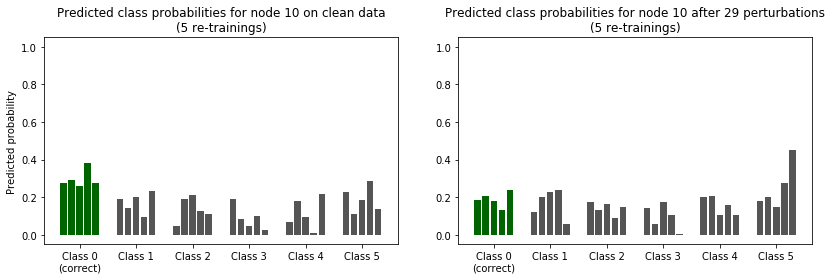

In [40]:
def make_xlabel(ix, correct):
    if ix==correct:
        return "Class {}\n(correct)".format(ix)
    return "Class {}".format(ix)

figure = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
center_ixs_clean = []
for ix, block in enumerate(class_distrs_clean.T):
    x_ixs= np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_clean.append(np.mean(x_ixs))
    color = '#555555'
    if ix == nettack.label_u:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)

ax=plt.gca()
plt.ylim((-.05, 1.05))
plt.ylabel("Predicted probability")
ax.set_xticks(center_ixs_clean)
ax.set_xticklabels([make_xlabel(k, nettack.label_u) for k in range(_K)])
ax.set_title("Predicted class probabilities for node {} on clean data\n({} re-trainings)".format(nettack.u, retrain_iters))

fig = plt.subplot(1, 2, 2)
center_ixs_retrain = []
for ix, block in enumerate(class_distrs_retrain.T):
    x_ixs= np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_retrain.append(np.mean(x_ixs))
    color = '#555555'
    if ix == nettack.label_u:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)


ax=plt.gca()
plt.ylim((-.05, 1.05))
ax.set_xticks(center_ixs_retrain)
ax.set_xticklabels([make_xlabel(k, nettack.label_u) for k in range(_K)])
ax.set_title("Predicted class probabilities for node {} after {} perturbations\n({} re-trainings)".format(nettack.u, n_perturbations, retrain_iters))
plt.tight_layout()
plt.show()